## Convolutional Neural Net for Classification of Traffic Sign Images

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.misc import imresize
import numpy as np
import pandas as pd
import random
from swat import *
from mpl_toolkits.axes_grid1 import ImageGrid
import sys
sys.path.append('/opt/sasinside/DemoData/DL_api')


# CAS Server Connection Details

In [57]:
cashost='localhost'
casport=5570
casauth='~/.authinfo'

# Start a CAS Server

In [58]:
s = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

In [60]:
 out = s.serverstatus()

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


# Load Actionsets

In [62]:
s.loadactionset('image')
s.loadactionset('deeplearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deeplearn'.


[actionset]

 'deeplearn'

+ Elapsed: 0.000213s, mem: 0.195mb

# Load Data

In [63]:
s.help(actionset='image')

NOTE: Information for action set 'image':
NOTE:    image
NOTE:       loadImages - Loads images from a path or URL and creates a CAS table
NOTE:       saveImages - Writes images contained in a CAS table to disk
NOTE:       compareImages - Compares images in one CAS table with those in another
NOTE:       processImages - Performs core image processing functions
NOTE:       augmentImages - Augment images by creating patches and mutating them
NOTE:       flattenImageTable - Convert image tables into wide format (one column per pixel)
NOTE:       summarizeImages - Read an image table and extract information about the images it contains
NOTE:       matchImages - Match a template image against a table of images
NOTE:       fetchImages - Fetch images for displaying
NOTE:       condenseImages - Condenses pixel values into a CAS image table.


,name,description
0,loadImages,Loads images from a path or URL and creates a ...
1,saveImages,Writes images contained in a CAS table to disk
2,compareImages,Compares images in one CAS table with those in...
3,processImages,Performs core image processing functions
4,augmentImages,Augment images by creating patches and mutatin...
5,flattenImageTable,Convert image tables into wide format (one col...
6,summarizeImages,Read an image table and extract information ab...
7,matchImages,Match a template image against a table of images
8,fetchImages,Fetch images for displaying
9,condenseImages,Condenses pixel values into a CAS image table.


In [64]:
# Loading images and labels from local disk
s.image.loadImages(casout={'name':'train','blocksize':128,'replace':True},
                   path='/opt/sasinside/DemoData/image/GTSRB/Final_Training/Images',recurse = 'True',labellevels =-1)
                        


NOTE: Loaded 39209 images from /opt/sasinside/DemoData/image/GTSRB/Final_Training/Images into Cloud Analytic Services table train.


+ Elapsed: 4.68s, user: 2.34s, sys: 2.34s, mem: 26.2mb

In [31]:
s.columninfo(table='train')

,Column,ID,Indexed,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,N,varbinary,164040,164040,0,0
1,_size_,2,N,int64,8,12,0,0
2,_path_,3,N,varchar,79,79,0,0
3,_label_,4,N,varchar,5,5,0,0
4,_type_,5,N,char,3,3,0,0
5,_id_,6,N,int64,8,12,0,0


In [65]:
from dl_api.images import ImageTable 
trainTb = s.CASTable('train')
tr_img = ImageTable.from_table(trainTb,image_col='_image_', label_col='_label_',path_col='_path_')

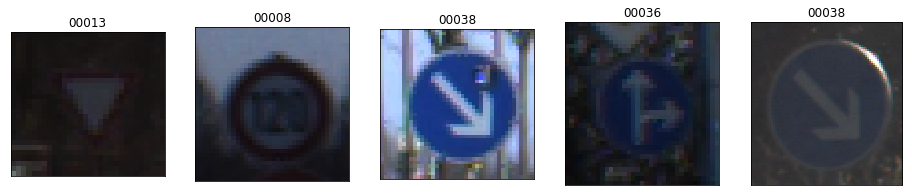

In [34]:
tr_img.show()

In [66]:
# Image preprocessing
# Resizing all images to 32 by 32 
s.image.processImages(imageTable="train",
                casout={'name':'trainWithSameSize_small'},
                imageFunctions =
                [
                     {
                        "functionOptions":
                         {
                            "functionType":"Resize",
                             'width':32,
                             'height':32
                              
                        }
                     }
                ]
            )   


NOTE: Table TRAIN contains compressed images.
NOTE: 39209 out of 39209 images were processed successfully and saved as compressed images to the Cloud Analytic Services table trainWithSameSize_small.


+ Elapsed: 0.819s, user: 3.86s, sys: 0.344s, mem: 44.3mb

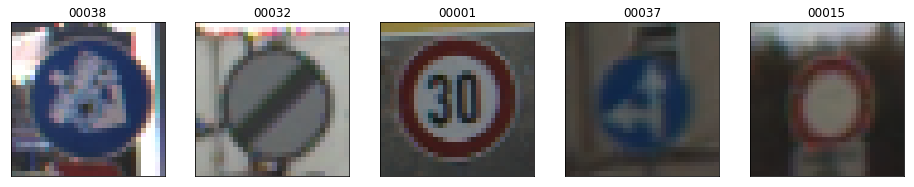

In [67]:
trainTb_small = s.CASTable('trainWithSameSize_small')
tr_img_small = ImageTable.from_table(trainTb_small,image_col='_image_', label_col='_label_',path_col='_path_')
tr_img_small.show()

In [69]:
# Rescale the image to [-0.5 to 0.5]
s.image.processImages(imageTable="trainWithSameSize_small",
                casout={'name':'trainWithSameSize_scale','replace':True, 'blocksize':128},
                imageFunctions =
                [
                     {
                        "functionOptions":
                         {
                            "functionType":"Rescale",
                             'type':"To_64F",
                              'alpha':1./255,
                              'beta':-0.5
                              
                        }
                     }
                ],
               decode=True,
            )  

NOTE: Table TRAINWITHSAMESIZE_SMALL contains compressed images.
NOTE: 39209 out of 39209 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table trainWithSameSize_scale.


+ Elapsed: 0.531s, user: 1.09s, sys: 1.07s, mem: 75.3mb

In [70]:
trainTb_scale = s.CASTable('trainWithSameSize_scale')
tr_img_scale = ImageTable.from_table(trainTb_scale,image_col='_image_', label_col='_label_',path_col='_path_')


In [71]:
# Training and validation
shuffleidSASCode = "call streaminit(-1);shuffle_id=rand(\"UNIFORM\");"
trainTbl0 = s.CASTable('trainWithSameSize_scale', computedvars=['shuffle_id'], computedvarsprogram=shuffleidSASCode, 
                       where='shuffle_id>0.3',
                       groupby='shuffle_id'
                      )
s.partition(table=trainTbl0, casout=dict(name='train_sampled', replace=True))

valiTbl0 = s.CASTable('trainWithSameSize_scale', computedvars=['shuffle_id'], computedvarsprogram=shuffleidSASCode, 
                       where='shuffle_id<0.3',
                       groupby='shuffle_id'
                      )
s.partition(table=valiTbl0, casout=dict(name='vali_sampled', replace=True))

[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'VALI_SAMPLED'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('VALI_SAMPLED', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.552s, user: 0.254s, sys: 0.312s, mem: 35.9mb

In [43]:
s.help(actionset='deepLearn')

NOTE: Information for action set 'deepLearn':
NOTE:    deepLearn
NOTE:       buildModel - Creates an empty deep learning model
NOTE:       addLayer - Adds a layer to a deep learning model
NOTE:       removeLayer - Removes a layer from a deep learning model
NOTE:       modelInfo - Shows model information
NOTE:       dlTune - Tunes hyperparameters for deep learning model
NOTE:       dlTrain - Trains a deep learning model
NOTE:       dlScore - Scores a table using a deep learning model
NOTE:       dlExportModel - Export a deep learning model
NOTE:       dlLabelTarget - Assign the target label information
NOTE:       dlImportModelWeights - Import model weights from an external source


,name,description
0,buildModel,Creates an empty deep learning model
1,addLayer,Adds a layer to a deep learning model
2,removeLayer,Removes a layer from a deep learning model
3,modelInfo,Shows model information
4,dlTune,Tunes hyperparameters for deep learning model
5,dlTrain,Trains a deep learning model
6,dlScore,Scores a table using a deep learning model
7,dlExportModel,Export a deep learning model
8,dlLabelTarget,Assign the target label information
9,dlImportModelWeights,Import model weights from an external source


In [72]:
# Create the model DAG
s.buildModel(model={'name' : 'tNet', 'replace': True}, type='CNN')

# Input layer
s.addLayer(model = 'tNet', name = 'images', 
             layer = dict(type = 'input',nchannels=3, width=32,height=32))
# First Convolutional Layer
s.addLayer(model = 'tNet', name = 'conv1',
           layer=dict(type = 'convolution',nFilters=32, width=3, height=3, stride=1,
                      init='NORMAL', std=0.1, truncationfactor=2, act='RELU'),
             srcLayers = ['images'])
# First pooling layer
s.addLayer(model = 'tNet', name = 'pool1',
           layer=dict(type = 'pooling',width=2, height=2, stride=2, pool='max'),
           srcLayers  = ['conv1'])
# Second Convolutional Layer
s.addLayer(model = 'tNet', name = 'conv2', 
           layer = dict(type = 'convolution',nFilters=64, width=3, height=3, stride=1,
                        init = 'NORMAL', std= 0.1, truncationfactor=2, act='RELU'),
           srcLayers = ['pool1'])
# Second pooling layer
s.addLayer(model = 'tNet', name = 'pool2', 
           layer = dict(type = 'pooling',width=2, height=2, stride=2, pool='max'),
           srcLayers  = ['conv2'])
# Third Convolutional Layer
s.addLayer(model = 'tNet', name = 'conv3', 
           layer = dict(type = 'convolution',nFilters=128, width=3, height=3, stride=1, 
                        init='NORMAL', std= 0.1, truncationfactor= 2, act= 'RELU'),
           srcLayers = ['pool2'])
# Third pooling layer
s.addLayer(model = 'tNet', name = 'pool3', 
           layer = dict(type = 'pooling',width=2, height=2, stride=2, pool='max'),
           srcLayers  = ['conv3'])
# Fully connected layer
s.addLayer(model = 'tNet', name = 'fc1', 
           layer = dict(type = 'fullconnect',n=512, act='relu', init='NORMAL', std=0.1, truncationfactor=2),
           srcLayers = ['pool3'])
# Softmax output layer
s.addLayer(model = 'tNet', name = 'outlayer', 
           layer = dict(type = 'output',act='softmax'),
           srcLayers = ['fc1'])


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),tnet,108,5,"CASTable('tnet', caslib='CASUSER(sasdemo)')"


In [47]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,39209,6,0,utf-8,18Oct2017:14:47:22,18Oct2017:14:47:22,18Oct2017:14:48:53,UTF8,1.823957e+09,1.823957e+09,1.823957e+09,0,0,0,,,0,sasdemo,
1,IMAGEDATA_RPXBLU,39209,3,0,utf-8,18Oct2017:14:47:46,18Oct2017:14:47:46,18Oct2017:14:48:41,UTF8,1.823957e+09,1.823957e+09,1.823957e+09,0,0,0,,,0,sasdemo,
2,TRAINWITHSAMESIZE_SMALL,39209,6,0,utf-8,18Oct2017:14:48:53,18Oct2017:14:48:53,18Oct2017:14:53:27,UTF8,1.823957e+09,1.823957e+09,1.823958e+09,0,0,0,,,0,sasdemo,
3,IMAGEDATA_ZYUMKP,39209,3,0,utf-8,18Oct2017:14:49:21,18Oct2017:14:49:21,18Oct2017:14:49:21,UTF8,1.823957e+09,1.823957e+09,1.823957e+09,0,0,0,,,0,sasdemo,
4,IMAGEDATA_WSBGID,39209,3,0,utf-8,18Oct2017:14:53:13,18Oct2017:14:53:13,18Oct2017:14:53:14,UTF8,1.823958e+09,1.823958e+09,1.823958e+09,0,0,0,,,0,sasdemo,
5,TRAINWITHSAMESIZE_SCALE,39209,9,0,utf-8,18Oct2017:14:53:27,18Oct2017:14:53:27,18Oct2017:14:53:45,UTF8,1.823958e+09,1.823958e+09,1.823958e+09,0,0,0,,,0,sasdemo,
6,IMAGEDATA_FTEORL,39209,3,0,utf-8,18Oct2017:14:53:49,18Oct2017:14:53:49,18Oct2017:14:53:51,UTF8,1.823958e+09,1.823958e+09,1.823958e+09,0,0,0,,,0,sasdemo,
7,TNET,108,5,0,utf-8,18Oct2017:14:55:27,18Oct2017:14:55:27,18Oct2017:14:55:27,UTF8,1.823958e+09,1.823958e+09,1.823958e+09,0,0,0,,,0,sasdemo,


In [73]:
# Train the model (SMP)
r =s.dltrain(model = 'tNet',
               table = {'name' : 'train_sampled'},
               seed = 99,
               nthreads = 8,
               input =['_image_','_label_'],
               target = '_label_',
               nominal = ['_label_'],
               modelweights = {'name' : 'tNet_Weights', 'replace' : True},
               learningOpts = {'miniBatchSize' : 1, 'maxEpochs' : 14, 'learningRate': 0.001, 'aSyncFreq' : 1, 'algorithm' : 'ADAM'})


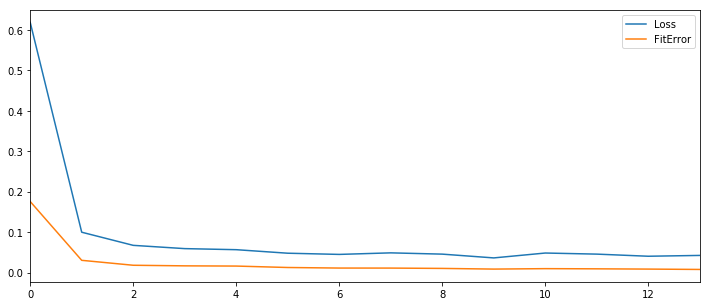

In [52]:
r.OptIterHistory[['Loss', 'FitError']].plot(figsize = (12, 5));

In [15]:
# Score against validation data
s.dlscore(model = 'tNet',
            initWeights = 'tNet_Weights',
            table = {'name' : 'vali_sampled'},
            copyVars = ['_label_'],
            layerOut = {'name' : 'tNet_LayerOut', 'replace' : True},
            casout = {'name' : 'tNet_Scored', 'replace' : True})

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         11760
 1  Number of Observations Used         11760
 2  Misclassification Error (%)      0.918367
 3                   Loss Error      0.075073

[OutputCasTables]

              casLib           Name   Rows  Columns  \
 0  CASUSER(sasdemo)  tNet_LayerOut  11760      454   
 1  CASUSER(sasdemo)    tNet_Scored  11760       47   
 
                                             casTable  
 0  CASTable('tNet_LayerOut', caslib='CASUSER(sasd...  
 1  CASTable('tNet_Scored', caslib='CASUSER(sasdem...  

+ Elapsed: 201s, user: 442s, sys: 135s, mem: 105mb

In [ ]:
# build a confusion matrix 
cmr = s.crosstab(table='tNet_scored', row='_label_', col='_dl_predname_')
cmr

/opt/sasinside/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


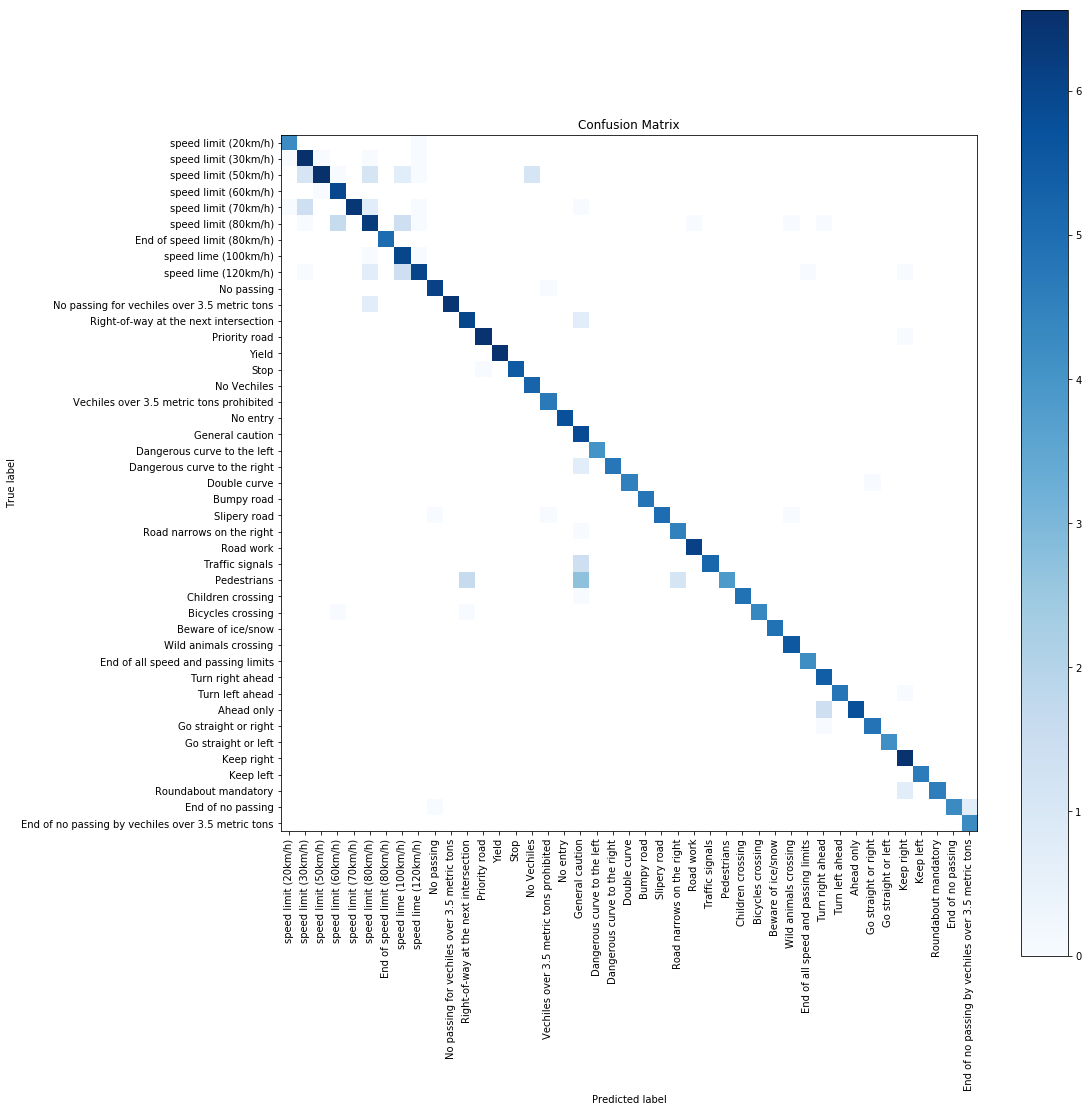

In [17]:
target_names = ["speed limit (20km/h)","speed limit (30km/h)","speed limit (50km/h)","speed limit (60km/h)","speed limit (70km/h)",
                "speed limit (80km/h)","End of speed limit (80km/h)","speed lime (100km/h)","speed lime (120km/h)","No passing",
                "No passing for vechiles over 3.5 metric tons","Right-of-way at the next intersection",
                "Priority road","Yield","Stop","No Vechiles","Vechiles over 3.5 metric tons prohibited","No entry","General caution",
                "Dangerous curve to the left","Dangerous curve to the right","Double curve","Bumpy road","Slipery road",
                "Road narrows on the right","Road work","Traffic signals","Pedestrians","Children crossing","Bicycles crossing",
                "Beware of ice/snow","Wild animals crossing","End of all speed and passing limits","Turn right ahead",
                "Turn left ahead","Ahead only","Go straight or right","Go straight or left","Keep right","Keep left",
                "Roundabout mandatory","End of no passing","End of no passing by vechiles over 3.5 metric tons"]
confM = cmr.Crosstab[['Col1','Col2','Col3','Col4','Col5','Col6','Col7','Col8','Col9','Col10',
                      'Col11','Col12','Col13','Col14','Col15','Col16','Col17','Col18','Col19','Col20',
                      'Col21','Col22','Col23','Col24','Col25','Col26','Col27','Col28','Col29','Col30',
                      'Col31','Col32','Col33','Col34','Col35','Col36','Col37','Col38','Col39','Col40',
                      'Col41','Col42','Col43'
                     ]].head(43).values

#confMNorm = confM.astype('float') / confM.sum(axis=1)[:, np.newaxis]
confMLogNorm = np.log(confM.astype('float')) 
#print confMLogNorm
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names,rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #grid off
    #labels = ['point {0}'.format(i + 1) for i in range(N)]
    #tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    #mpld3.plugins.connect(fig, tooltip)
    
plt.figure(figsize=(16,16))
plot_confusion_matrix(confMLogNorm) 

In [25]:
s.close()